In [1]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

C:\Users\pajag\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pajag\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4sp5sua7cbgxueoc35yp2asoicyyeqzz.gfortran-win_amd64.dll
C:\Users\pajag\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
base_model = vgg19.VGG19(weights='imagenet', include_top=False)
base_model.trainable = False

In [3]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [4]:
content_outputs = [base_model.get_layer(layer).output for layer in content_layers]
style_outputs = [base_model.get_layer(layer).output for layer in style_layers]
model_outputs = content_outputs + style_outputs
style_model = Model(inputs=base_model.input, outputs=model_outputs)

In [5]:
def preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [6]:
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [7]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [8]:
def style_loss(base_style, gram_target):
    _, height, width, channels = base_style.get_shape().as_list()
    gram_style = tf.linalg.einsum('bijc,bijd->bcd', base_style, base_style) / (height * width * channels)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [10]:
def compute_losses(base_image, content_targets, style_targets):
    content_activations = style_model(base_image)[0]
    style_activations = style_model(base_image)[1:]
    content_loss_val = content_loss(content_activations, content_targets)
    style_loss_val = 0
    for layer, target in zip(style_activations, style_targets):
        style_loss_val += style_loss(layer, target)
    return content_loss_val, style_loss_val

In [19]:
def style_transfer(content_path, style_path, num_iterations=10, content_weight=1e3, style_weight=1e-2):
    content_image = preprocess_image(content_path)
    style_image = preprocess_image(style_path)
    content_target_activations = style_model(content_image)[0]
    style_target_activations = style_model(style_image)[1:]
    style_targets = [tf.linalg.einsum('bijc,bijd->bcd', layer, layer) for layer in style_target_activations]
    opt_img = tf.Variable(content_image, dtype=tf.float32)
    optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            content_loss_val, style_loss_val = compute_losses(opt_img, content_target_activations, style_targets)
            total_loss = content_weight * content_loss_val + style_weight * style_loss_val
        gradients = tape.gradient(total_loss, opt_img)
        optimizer.apply_gradients([(gradients, opt_img)])
        if i % 100 == 0:
            print(f"Iteration: {i}, Total Loss: {total_loss.numpy()}, Content Loss: {content_loss_val.numpy()}, Style Loss: {style_loss_val.numpy()}")
    return deprocess_image(opt_img.numpy())

Iteration: 0, Total Loss: 3.0653241721094144e+16, Content Loss: 0.0, Style Loss: 3.065324343908106e+18


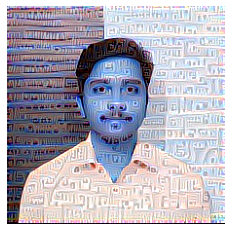

In [20]:
result_image = style_transfer('C://Users//pajag//CL3//Photo1.jpg', 'C://Users//pajag//CL3//dht2.png')
plt.imshow(result_image)
plt.axis('off')
plt.show()